In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from rlway.pyosrd import OSRD
small_infra = OSRD('../cases/small_infra/')

In [38]:
small_infra = OSRD('../cases/small_infra/')

In [141]:
from typing import Tuple, List

import folium
import numpy as np
from folium import plugins

from haversine import haversine, Unit


In [40]:

track_section_coordinates = {
    ts['id']: [(point[1], point[0]) for point in ts['geo']['coordinates']]
    for ts in small_infra.infra['track_sections']
}

track_section_geo_lengths = {
    ts['id'] : haversine(
        (
            ts['geo']['coordinates'][0][1],
            ts['geo']['coordinates'][0][0]
        ),
        (
            ts['geo']['coordinates'][-1][1],
            ts['geo']['coordinates'][-1][0]
        ),
        unit='m'
    )
    for ts in small_infra.infra['track_sections']
}

In [41]:
def coords_from_position_on_track(
    track_section: str,
    position: float,
) -> List[float]:
    length = small_infra.track_section_lengths[track_section]
    pos = position / length
    positions = [
        haversine(point, track_section_coordinates[track_section][0], unit='m')
        / track_section_geo_lengths[track_section]
        for point in track_section_coordinates[track_section]
    ]
    lats = [coord[0] for coord in track_section_coordinates[track_section]]
    longs = [coord[1] for coord in track_section_coordinates[track_section]]
    return [
        np.interp([pos], positions, lats).item(),
        np.interp([pos], positions, longs).item(),
    ]

In [42]:

detector_geo_positions = {
    detector['id']: coords_from_position_on_track(detector['track'], detector['position'])
    for detector in small_infra.infra['detectors']
}
signal_geo_positions = {
    signal['id']: coords_from_position_on_track(signal['track'], signal['position'])
    for signal in small_infra.infra['signals']
}

station_geo_positions = {
    station['id'] + '_' + part['track']: coords_from_position_on_track(part['track'], part['position'])
    for station in small_infra.infra['operational_points']
    for part in station['parts']
}

switch_geo_positions = {
    switch['id']: coords_from_position_on_track(
        switch['ports'][list(switch['ports'].keys())[0]]['track'],
        0
        if switch['ports'][list(switch['ports'].keys())[0]]['endpoint'] == 'BEGIN'
        else small_infra.track_section_lengths[
            switch['ports'][list(switch['ports'].keys())[0]]['track']
        ]
    )
    for switch in small_infra.infra['switches']
}

In [142]:

m = folium.Map(location=[49.5, -0.4])
tracks = folium.FeatureGroup(name='small_infra')
for id, line in track_section_coordinates.items():
    folium.PolyLine(line, tooltip=id, color='black').add_to(tracks)
tracks.add_to(m)

m.fit_bounds(tracks.get_bounds())

detectors = folium.FeatureGroup('Detectors')
for id, position in detector_geo_positions.items():
    folium.Marker(
        position,
        popup=id,
        icon=folium.DivIcon(html=f"""
        <div><svg>
            <rect x="-5" y="-5" width="20" height="20", fill="green", opacity=".3" />
        </svg></div>"""),
        ).add_to(detectors)
detectors.add_to(m)

signals = folium.FeatureGroup('Signals')
for id, position in signal_geo_positions.items():
    folium.Marker(
        position,
        popup=id,
        icon=folium.DivIcon(html=f"""
        <div><svg>
            <circle cx="5" cy="5" r="5", fill="red", opacity=".3" />
        </svg></div>"""),
        ).add_to(signals)
signals.add_to(m)

stations = folium.FeatureGroup('Stations')
for id, position in station_geo_positions.items():
    folium.Marker(
        position,
        popup=id,
        icon=folium.DivIcon(html=f"""
        <div><svg>
            <rect x="-10" y="-10" width="40" height="20", fill="gray", opacity=".6" />
        </svg></div>"""),
        ).add_to(stations)
stations.add_to(m)

switches = folium.FeatureGroup('Switches')
for id, position in switch_geo_positions.items():
    folium.Marker(
        position,
        popup=id,
        icon=folium.DivIcon(html=f"""
        <div><svg>
            <circle cx="5" cy="5" r="5", fill="black", opacity=".3" />
        </svg></div>"""),
        ).add_to(switches)
switches.add_to(m)

folium.LayerControl().add_to(m)

m.add_child(plugins.Fullscreen())
m

<Axes: title={'center': 'train.0 (eco)'}, xlabel='Time [min]'>

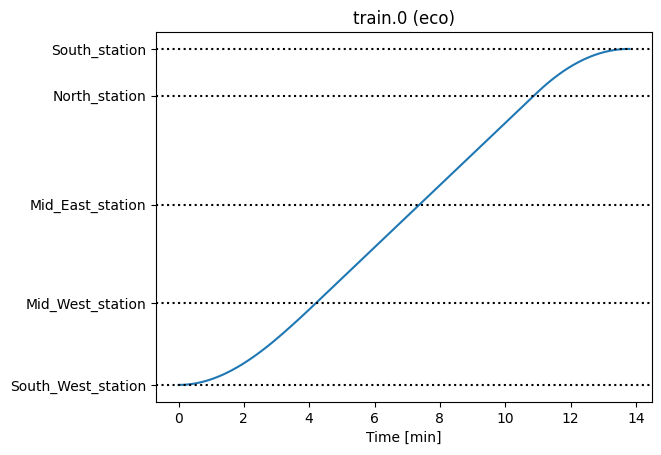

In [139]:
small_infra.space_time_graph(0, types_to_show=['station'])

In [135]:
set(small_infra.points_encountered_by_train(0)).union(set(small_infra.points_encountered_by_train(1)))

TypeError: unhashable type: 'dict'

In [137]:
set(small_infra.points_encountered_by_train(1))

TypeError: unhashable type: 'dict'